# Fischer Linear Discriminant Analysis

Kernel Fisher Discriminant Analysis (Kernel FDA) e um metodo de reducao de dimensionalidade e classificacao, capaz de projetar datasets com grande numero de dimensoes em sub-espacos reduzidos, assim como PCA e o LDA. Esse sub-espaco e otimizado para maximizar a dispersao entre classes e minimizar a dispersao intra-classes, assim como o LDA. A vantagem dessa versao e que ela implementa o kernel trick, assim como o SVM e o Kernel PCA, possibilitando uma representacao dos dados antes nao linearmente separaveis em um sub-espaco reduzido em que as classes sejam linearmente separaveis.

O Kernel FDA classifica os vetores comparando suas projecoes no sub-espaco com os centroids das classes. Com isso em mente, adicionar uma nova classe pode significar simplesmente adicionar um novo centroid. Nesse sentido, no exemplo de hoje vamos abordar o Kernel FDA nao apenas para reducao de dimensionalidade, mas tambem para classificacao e `one shot learning`.

## Instalando o pacote

Podemos utilizar uma implementacao do kfda disponivel [aqui](https://pypi.org/project/kfda/).

In [30]:
!pip install kfda

## Carregando o dataset

Vamos usar o  dataset MNIST para um primeiro exemplo. Utilizaremos apenas 8000 amostras para economizar tempo e memoria.

In [29]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X - 127.5) / 127.5

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=10000, stratify=y)

Como uma boa pratica, podemos vizualizar os dados:

In [28]:
import matplotlib.pyplot as plt
import random
import itertools

test_indices = random.sample(range(X_test.shape[0]), 16)
test_sample = X_test[test_indices]
test_sample_labels = y_test[test_indices]

f, axs = plt.subplots(4, 4)
flattened_axs = itertools.chain(*axs)

for ax, img, label in zip(flattened_axs, test_sample, test_sample_labels):
    ax.axis('off')
    ax.imshow(img.reshape(28,28))
    ax.set_title(f'Label: {label}')

plt.tight_layout()

## Treinamento

O `Kfda` foi implementado de modo a ter uma interface similar ao `scikit-learn`.

Sendo assim, podemos usar apenas `.fit` para iniciar o treinamento.

In [27]:
from kfda import Kfda
cls = Kfda(kernel='rbf', n_components=9)
cls.fit(X_train, y_train)

## Avaliando o modelo

Podemos usar `.score()` para avaliar o modelo. Nesse exemplo, o resultado fica frequentemente por volta de 0.97, indicando uma acuracia de 97%.

In [26]:
print('Resultados:')
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de testes: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

Visualizando as predicoes para ter uma ideia de onde o classificador acertou ou errou. Nesse caso, o modelo conseguiu uma acuracia de 97%.

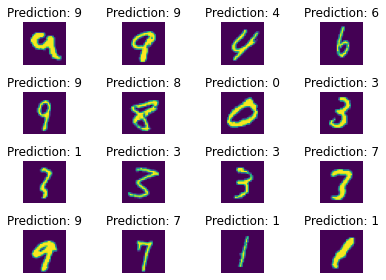

In [7]:
predictions = cls.predict(test_sample)

f, axs = plt.subplots(4, 4)

flattened_axs = itertools.chain(*axs)

for ax, img, prediction in zip(flattened_axs, test_sample, predictions):
    (ax.axis('off'))
    ax.imshow(img.reshape(28,28))
    ax.set_title(f'Prediction: {prediction}')
plt.tight_layout()

# Oneshot Learning

Esse exemplo sera treinado considerando apenas amostras de digitos de 0 a 8. A ideia e apresentar uma amostra de classe 9 e que, sem nenhum retreino, o modelo seja capaz de identificar que a amostra pertence a uma nova classe. Vamos primeiro separar os 9's do conjunto de treinamento.

In [9]:
nines_mask = y_train == '9'
X_train_nines = X_train[nines_mask]
X_train = X_train[~nines_mask]
y_train_nines = y_train[nines_mask]
y_train = y_train[~nines_mask]

Agora vamos treinar o modelo considerando apenas as amostras de classe entre 0 e 8. Note que n_componentes e 8 em vez de 9. Isso pq o numero maximo de direcoes no sub-espaco de fischer e $c-1$, e agora so temos 9 classes.

In [25]:
cls = Kfda(kernel='rbf', n_components=8)
print('Fitting...')
cls.fit(X_train, y_train)

Podemos utilizar `.fit_additional` para introduzir uma nova classe. Qualquer quantidade de novas classes podem ser fornecidas. Nenhum retreino e executado, o que pode ser observado na execucao muito rapida.

In [24]:
cls.fit_additional(X_train_nines[:1], y_train_nines[:1])

Qualquer quantidade de novas amostras de treinamento para multiplas classes podem ser introduzidas utilizando `.fit_additional`. O resultado final fica em torno de 0.95, o que implica que o classificador foi  capaz de reconhecer os 9s com sucesso.

In [23]:
print('Resultados:')
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de testes: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

# Visualizando as representacoes

Podemos rodar o codigo abaixo para gerar as representacoes, que podem alimentar o [Projetor](https://projector.tensorflow.org/) do Tensorflow para produzir uma visualizacao UMAP.

In [22]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

from kfda import Kfda


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X - 127.5) / 127.5

# If you don't have that much memory available, lower this number.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=10000, stratify=y)


# Remove nines from the training set
nines_mask = y_train == '9'
X_train_nines = X_train[nines_mask]
X_train = X_train[~nines_mask]
y_train_nines = y_train[nines_mask]
y_train = y_train[~nines_mask]

# Train
cls = Kfda(kernel='rbf', n_components=8)
print('Ajustando...')
train_embeddings = cls.fit_transform(X_train, y_train)

# Mostra um unico 9 para o algoritmo.
# Os mesmos pesos sao usados e nao ha re-treinamento.
print('Adicionando a classe 9')
cls.fit_additional(X_train_nines[:1], y_train_nines[:1])
print('Resultados:')

# Mostra os resultados
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de testes: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

print('Gerando as representacoes...')
test_embeddings = cls.transform(X_test)

np.savetxt('mnist_oneshot_test_embeddings.tsv',
           test_embeddings, delimiter='\t')
np.savetxt('mnist_oneshot_test_labels.tsv', y_test, delimiter='\t', fmt="%s")
np.savetxt('mnist_oneshot_train_labels.tsv', y_train, delimiter='\t', fmt="%s")
print('Representacoes salvas em *.tsv! Conecte-as https://projector.tensorflow.org/ para visualizacao.')

Cada cor representa um digito diferente, e as representacoes mostram claramente que as classes sao separaveis.

Podemos tambem observar o quao efetiva sao essas representacoes em apenas 2 dimensoes. Quando usamos apenas 2 componentes em vez de 9 teremos uma classificacao menos acurada, porem, e uma abordagem muito util para mostrar visualmente o quanto efetivo apenas 2 componentes podem ser. 

Vamos primeiro treinar um novo classificador:

In [21]:
# Recarregando os dados
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X - 127.5) / 127.5

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=10000, stratify=y)

# Treinando o classificador
cls = Kfda(kernel='rbf', n_components=2)
train_embeddings = cls.fit_transform(X_train, y_train)

# computando os resultados
test_score = cls.score(X_test, y_test)
print(f'Resultado sobre conjunto de testes: {test_score}')

Como esperado, utilizar um numero menor de componentes leva a uma queda consideraval na acuracia. As representacoes das amostras de treinamento ficam assim:

In [20]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'slategray', 'darkorange', 'lime']
for label, color in zip(cls.classes_, colors):
    class_embeddings = train_embeddings[y_train == label]
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], c=color, label=label)
plt.legend()

Apesar de mostrar um boa separacao entre as classes, as representacoes das classes nao sao interessantes por que ficam praticamente clusterizadas. Ja as representacoes de teste:

In [19]:
test_embeddings = cls.transform(X_test)

for label, color in zip(cls.classes_, colors):
    class_embeddings = test_embeddings[y_test == label]
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], c=color, label=label)
plt.legend()

Essas amostras estao propensas a ficarem sobrepostas, e as classes se apresentam agrupadas. Nesse caso, adicionar uma quantidade maior de dimensoes e essencial para conseguirmos separar essas amostras.